In [1]:
import numpy as np
np.set_printoptions(precision=None, suppress=True) 
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from math import sqrt
from scipy.stats import variation, spearmanr, boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from IPython.display import display, HTML
#Sklearn imports
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
#Keras imports
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Input, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#ARIMA imports
import pmdarima as pm
from pmdarima import pipeline as arimapipe
from pmdarima import preprocessing as ppc
#Optimization imports
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer 
from skopt.utils import use_named_args
from fbprophet import Prophet
from tsfeatures import tsfeatures
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disabling GPU

**Import dataset**

In [2]:
df = pd.read_csv("data/covid19.csv", 
                 dtype = {"Country/Region": str, "Province/State": str, "Latitude": float, "Longitude": float, 
                 "Confirmed": float, "Recovered": float, "Deaths": float, "Date": str})
df["Confirmed"].fillna(0, inplace = True)
df["Deaths"].fillna(0, inplace = True)
df["Recovered"].fillna(0, inplace = True)

In [3]:
"""
Analytic functions

"""

def smape(actual, predict):
    """Symmetric mean absolute percentage error"""
    return (100 / len(actual)) *\
        ((np.sum(np.abs(predict - actual) / 
         (np.abs(actual) + np.abs(predict)) / 2)))

def analyze_forecast(train_values, test_values, predict_values):

    """Display a table of measurements"""
    df_table = pd.DataFrame()
    df_table["sMAPE"] = [smape(test_values.values, predict_values.values)]
    #Scale independent measure
   # df_table["Smooth-StdDiff"] = np.std(np.diff(np.squeeze(train_values)))/\
   #                                  np.abs(np.mean(np.diff(np.squeeze(train_values))))
    df_table["Smooth-Variation"] = variation(train_values)
    adftest = adfuller(train_values, regression= 'ct')
    #df_table["ADF Test"] = [adftest[0]]
   # df_table["ADF PVal"] = [adftest[1]]
    df_table["SVD entropy"] =  svd_entropy(np.squeeze(train_values), normalize=True)
   # df_table["Sample entropy"] =  sampen(np.squeeze(train_values))
   # df_table["Spectral"] =  spectral_entropy(np.squeeze(train_values), 100)
    #df_table["Defluctuation"] = dfa(np.squeeze(train_values.astype(np.float32)))
    display(HTML(df_table.to_html(index = False)))     

In [4]:
def split_featured_data(df, feature, country,
                        observation_start, observation_end, test_date):  
    df = df.copy()
    data = df[df["Country/Region"] == country]   
    #Sum sub regions daily counts
    data = data.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
    data = data[["Date", feature]]
    data = data.set_index("Date")
    data['unique_id'] = country
    #remove 0 values - made large plots
    data = data[data[feature] != 0]
    smooved_data = data.rolling(2, min_periods = 2).mean()
    #find indices of training data
    i_start = np.where(data.index.to_numpy() == observation_start)[0][0]  
    i_end = np.where(data.index.to_numpy() == observation_end)[0][0] 
    i_validate = np.where(data.index.to_numpy() == test_date)[0][0] 
    x = smooved_data[i_start:i_end]
    y = data[i_end:i_validate]
    y = y.drop(columns=['unique_id'])
    x = x.astype('int32')
    y = y.astype('int32')
                    #Meta features to include
                     #SVD entropy & Smoothness with variation : higest Spearman's correlation
                    #Last two positions in data [-2:-1]
    data = data.rename(columns={"Date": "ds", "Confirmed":"y"})
    # Add tsfeatures
    tsfeats = tsfeatures(data, 7)
    tsfeats.insert(0, 'svd_entropy', svd_entropy(np.squeeze(x), normalize=True))
    tsfeats.insert(0, 'variation', variation(np.squeeze(x)))
        
    # Remove these, only required by tsfeatures
    data = data.rename(columns={"ds": "Date", "y":"Confirmed"})
    data = data.drop(columns=['unique_id'])
    return data, x, y, tsfeats

# Base models

In [5]:
def holt(df, feature, country, 
         observation_start, observation_end, test_date): 
    #Split data 
    data, x, y, meta_features = split_featured_data(df, feature, country, 
                                     observation_start, observation_end, test_date)
    box_cox_train = boxcox(np.squeeze(x.values))
    #HW model
    model = ExponentialSmoothing(box_cox_train[0], trend='add', seasonal=None).fit(
            use_basinhopping= True,
            smoothing_level = 0.6)
    forecasts = model.forecast(len(y))
    #inverese
    forecasts = inv_boxcox(forecasts, box_cox_train[1])
    return forecasts.astype(np.int), np.squeeze(y.values), meta_features

In [6]:
def arima(df, feature, country, 
         observation_start, observation_end, test_date): 
    #Split data 
    data, x, y, meta_features = split_featured_data(df, feature, country, 
                                     observation_start, observation_end, test_date)
    #ARIMA model
    boxcox = ppc.BoxCoxEndogTransformer(lmbda = None, lmbda2=5)
    pipe = arimapipe.Pipeline([
        ("boxcox", boxcox), 
        ("arima", pm.AutoARIMA(
                start_p = 0, start_q = 0,  
                test = "adf", 
                max_p = 5, max_q = 5,
                seasonal = False, m = 1,
                d = None,              
                trace = False,
                stepwise = False,          #Parallelized 
                suppress_warnings = True,
                error_action = "ignore",
                return_valid_fits = True
        ))])
    pipe.fit(x.values)
    forecasts  = pipe.predict(len(y))
    return forecasts.astype(np.int), np.squeeze(y.values), meta_features

In [7]:
def prophet(df, feature, country, 
         observation_start, observation_end, test_date): 
    #Split data 
    data, x, y, meta_features = split_featured_data(df, feature, country, observation_start, observation_end, test_date)
    prophet_x = x.reset_index().copy()
    prophet_x.columns = ['ds','y']
    #Prophet model
    model = Prophet(growth = 'linear',changepoint_prior_scale = 0.5,n_changepoints = 14,
                    daily_seasonality=False, yearly_seasonality=False)
    model.fit(prophet_x)
    future_df = model.make_future_dataframe(periods=len(y))
    forecasts = model.predict(future_df)
    
    forecasts = forecasts[forecasts['ds'] >= observation_end]
    forecasts = [forecast for forecast in forecasts.yhat]
    return np.array(forecasts).astype(np.int), np.squeeze(y.values), meta_features

In [8]:
def lstm(df, feature, country, 
         observation_start, observation_end, test_date): 
    #Split data 
    data, x, y, meta_features = split_featured_data(df, feature, country, 
                                     observation_start, observation_end, test_date)
    #Scale data
    scaler = MinMaxScaler().fit(x)
    train_scaled = scaler.transform(x)
    #LSTM model
    n_observations = 8
    model = Sequential()
    model.add(Input(shape = (n_observations, 1)))
    model.add(LSTM(units = 192, return_sequences = True, activation = "tanh", recurrent_activation = "sigmoid"))
    model.add(LSTM(units = 384, return_sequences = True, activation = "tanh", recurrent_activation = "sigmoid"))
    model.add(LSTM(units = 384, activation = "tanh", recurrent_activation = "sigmoid"))
    model.add(Dense(units = 1, activation = None))
    model.compile(optimizer = Adam(lr=0.00001), loss = "mae") 
    generator = TimeseriesGenerator(train_scaled, train_scaled, length = n_observations, batch_size = 4) 
    model.fit(generator, verbose = 0, epochs = 110) 
    #Predictions
    forecasts = []
    batch = (train_scaled[-n_observations:]).reshape((1, n_observations, 1))
    for entry in range(len(y)): 
        forecast = model.predict(batch)[0]
        forecasts.append(forecast) 
        batch = np.append(batch[:,1:,:],[[forecast]], axis = 1)
    return np.squeeze(scaler.inverse_transform(forecasts)).astype(np.int), np.squeeze(y.values), meta_features

In [9]:
def get_base_model_data(models : list, countries : list, features : list, 
                        start_date, end_date, validate_date):
    """
    Runs the base models to make forecast data and retrieves meta-data for the curve that was forecast
    
    
    """
    x = np.ndarray((0, len(models)))
    y = np.ndarray((0, ))
    all_scores = []
    stored_targets = False
    meta_features_per_curve = {}
    for country in countries:
        print(country)
        meta_values = []
        for feature in features:
            forecast_values = []
            scores = []
            targets_stored = False
            for model in models:
                #Forecast 
                forecast, actual, meta_features = models[model](df, feature, country, 
                                                 start_date, end_date, validate_date)
                #Store results
                forecast_values.append(forecast)
                scores.append(smape(actual, forecast))
                meta_values.append(meta_features)
                #Only use first model's actual return
                if not targets_stored:
                    y = np.hstack((actual.T, y))
                    targets_stored = True
                    
            x = np.vstack((np.array(forecast_values).T, x))
    
            #Store sMAPE scores
            all_scores.append(scores)
            
        #Store meta features with forecasts
        meta_features_per_curve[country] = meta_values 
        
    #Stack 
    return x, y, np.array(all_scores), np.array(meta_features_per_curve)

**Conifg**

In [10]:
train_start_date = "2020-04-01"
train_end_date = "2020-05-01"
test_start_date = "2020-05-15"
test_end_date = "2020-06-14"
validate_date = "2020-06-28"

models = {'holt': holt,
          'arima': arima,
          'prophet': prophet,
          'lstm': lstm}

countries_to_forecast = ["South Africa", "Italy", "US", "Russia",
                         "United Kingdom", "Peru", "Algeria", "Japan", 
                         "Brazil", "Mexico", "Australia", "Germany",
                         "Poland", "Turkey", "India", "Kenya",
                         "Lebanon", "Chile", "Bangladesh", "France"]


features = ["Confirmed"]
load_from_file = True

**Base models Phase-1 predictions** <br><br>
train_x: Phase 1 base models' forecasts (Meta-learning inputs)<br>
train_y: Phase 1 targets <br>

In [11]:
if not load_from_file:
    train_x, train_y, train_score, train_meta_features = get_base_model_data(models, countries_to_forecast, features, train_start_date, train_end_date, test_start_date)
    np.save("train_x_14_confirmed", train_x)
    np.save("train_y_14_confirmed", train_y)
    np.save("train_score_14_confirmed", train_score)
    np.save("train_metas_14", train_meta_features)
else:
    train_x = np.load("train_x_14_confirmed.npy")
    train_y = np.load("train_y_14_confirmed.npy")
    train_score = np.load("train_score_14_confirmed.npy") 
    train_meta_features = np.load("train_metas_14.npy", allow_pickle=True)

**Base models Phase-2 predictions** <br><br>
test_x: Phase 2 base models' forecasts (Meta-learner inputs) <br>
test_y: Phase 2 targets

In [12]:
if not load_from_file:
    test_x, test_y, test_score, test_meta_features = get_base_model_data(models, countries_to_forecast, features, test_start_date, test_end_date, validate_date)
    np.save("test_x_14_confirmed", test_x)
    np.save("test_y_14_confirmed", test_y)
    np.save("test_score_14_confirmed", test_score)
    np.save("test_metas_14_confirmed", test_meta_features)
else:
    test_x = np.load("test_x_14_confirmed.npy")
    test_y = np.load("test_y_14_confirmed.npy")
    test_score = np.load("test_score_14_confirmed.npy")
    test_meta_features = np.load("test_metas_14_confirmed.npy", allow_pickle=True)

In [13]:
train_meta_features = train_meta_features.tolist()
test_meta_features = test_meta_features.tolist()

In [14]:
train_metas = {}
for country in train_meta_features.copy():
    for feat in ['unique_id', 'series_length', 'hurst','hw_gamma', 'hw_alpha', 'hw_beta', 'entropy', 'nperiods', 'alpha', 'beta',
            'spike', 'linearity', 'crossing_points', 'seasonal_period', 'curvature', 'e_acf','e_acf1', 'e_acf10', 'trend']:
        try:
            train_meta_features[country][0] = train_meta_features[country][0].drop(columns=[feat])
        except:
            do_nothing = True
            
    train_metas[country] = train_meta_features[country][0]
    
test_metas = {}  
for country in test_meta_features.copy():
    for feat in ['unique_id', 'series_length', 'hurst','hw_gamma', 'hw_alpha', 'hw_beta', 'entropy', 'nperiods', 'alpha', 'beta',
            'spike', 'linearity', 'crossing_points', 'seasonal_period', 'curvature', 'e_acf','e_acf1', 'e_acf10', 'trend']:
        try:
            test_meta_features[country][0] = test_meta_features[country][0].drop(columns=[feat])
        except:
            do_nothing = True
            
    test_metas[country] = test_meta_features[country][0]

**Analyse training data**

In [15]:
df_analyse = pd.DataFrame()
forecast_length = 14
#for model in models:
i_mod = 0

actual = train_y.reshape(len(countries_to_forecast)*len(features), forecast_length)
col_names = ['Model', 'sMAPE']
cols_assigned = False
for model in models.keys():
    forecasts = train_x[:,i_mod]
    forecasts = forecasts.reshape(len(countries_to_forecast)*len(features), forecast_length)
    i_forecast = 0
    for forecast, country in zip(forecasts, countries_to_forecast):
        act_vals = actual[i_forecast,:]
        adftest = adfuller(act_vals)
        # Meta features
        result = [model, smape(act_vals, forecast)]
        for feat, val in train_meta_features[country][0].items():
            result.append(val.values[0])
            if not cols_assigned:
                col_names.append(feat)
        cols_assigned = True
        result = [result]
        df_analyse = df_analyse.append(result, ignore_index=True)
        i_forecast += 1              
    i_mod += 1
df_analyse.columns = col_names
df_analyse

,Model,sMAPE,variation,svd_entropy,unitroot_pp,unitroot_kpss,stability,seasonal_strength,peak,trough,...,garch_r2,flat_spots,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,holt,0.214861,0.427430,0.058922,2.917437,2.518525,1.000787,0.745353,4,6,...,0.315828,98,0.999955,0.978540,7.660029,0.966212,8.124293,-0.053195,0.519378,0.837049
1,holt,1.608215,0.178347,0.039300,-0.959678,3.588354,1.030042,0.507861,3,6,...,0.317014,86,0.999954,0.990900,8.903286,0.976324,7.965228,-0.029439,0.380112,0.927454
2,holt,5.777405,0.403138,0.072079,2.505572,3.828985,0.979649,0.733166,3,7,...,0.247697,80,0.999989,0.983203,8.243995,0.978352,8.337421,-0.023634,0.660009,0.881070
3,holt,1.332738,0.873691,0.091159,1.251856,3.802182,1.030342,0.156593,5,7,...,0.353068,88,0.999997,0.988691,8.749038,0.990761,8.883753,-0.152805,0.183727,0.916873
4,holt,5.747149,0.439203,0.081015,-0.292783,3.837494,1.030142,0.203779,6,7,...,0.001329,70,0.994761,0.992112,9.058154,0.406574,1.456750,-0.496608,0.247722,0.938067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,lstm,0.772357,0.375400,0.099362,4.342308,2.406030,1.035271,0.508670,3,5,...,0.302152,88,0.999850,0.968739,6.984077,0.881969,6.774974,-0.496503,0.394526,0.784607
76,lstm,1.667776,0.120473,0.046900,7.280316,2.639874,1.025418,0.308619,3,5,...,0.130025,76,0.999421,0.954433,6.176655,0.830819,4.261927,-0.560910,0.397008,0.718197
77,lstm,0.469896,0.424486,0.061840,0.939721,3.167462,0.998255,0.138040,2,1,...,0.001570,73,0.999319,0.987690,8.600516,0.391062,1.525986,-0.531322,0.287252,0.906385
78,lstm,0.484328,1.033671,0.116685,1.757025,2.999539,0.930124,0.444559,6,2,...,0.023764,74,0.999954,0.983507,8.245949,0.968906,8.160581,-0.213148,0.173263,0.881263


Person's correlation test: <br>
Values >= 0.5 have strong correlation

In [117]:
#Test each parameter's correlation with sMAPE
for model in models.keys():
    print(model)
    df_new =df_analyse.loc[df_analyse['Model'] == model]
    for column in df_new.columns:
        if column != "Model":
            if column == "sMAPE":
                print("Avg sMAPE : " + str(np.mean(df_new["sMAPE"].values)))
                continue
                
            corr = spearmanr(df_new[column].values, df_new["sMAPE"].values)
            print("Spearman's corr ["+column+"] = " + str(round(abs(corr[0]),2)))

holt
Avg sMAPE : 1.4211305510265553
Spearman's corr [variation] = 0.29
Spearman's corr [svd_entropy] = 0.27
Spearman's corr [unitroot_pp] = 0.04
Spearman's corr [unitroot_kpss] = 0.38
Spearman's corr [stability] = 0.09
Spearman's corr [seasonal_strength] = 0.28
Spearman's corr [peak] = 0.22
Spearman's corr [trough] = 0.29
Spearman's corr [x_pacf5] = 0.12
Spearman's corr [diff1x_pacf5] = 0.17
Spearman's corr [diff2x_pacf5] = 0.11
Spearman's corr [seas_pacf] = 0.09
Spearman's corr [nonlinearity] = 0.34
Spearman's corr [lumpiness] = 0.19
Spearman's corr [arch_acf] = 0.09
Spearman's corr [garch_acf] = 0.09
Spearman's corr [arch_r2] = 0.04
Spearman's corr [garch_r2] = 0.04
Spearman's corr [flat_spots] = 0.08
Spearman's corr [arch_lm] = 0.15
Spearman's corr [x_acf1] = 0.13
Spearman's corr [x_acf10] = 0.17
Spearman's corr [diff1_acf1] = 0.05
Spearman's corr [diff1_acf10] = 0.08
Spearman's corr [diff2_acf1] = 0.23
Spearman's corr [diff2_acf10] = 0.06
Spearman's corr [seas_acf1] = 0.17
arima
Av

For model:<br>
holt : sMAPE is predictable by the SVD-Entropy  <br>
arima : sMAPE is predictable by the Smooth-Var and SVD-Entropy <br>
lstm : sMAPE is predictable by the Smooth-Var

# Meta-learner

**Learn from phase-1 data**

In [83]:
def get_meta_params(train_x, train_y, n_calls=100):
    
    # Bayesian optimisation dimsensions
    dimensions =[
        Integer(low=1, high=5, name= 'layers'),
        Integer(low=10, high=300, name= 'units'),
        Integer(low=180, high=400, name= 'epochs'),
        Real(low=1e-5, high=1e-3, prior='log-uniform', name='alpha')
       ]
    default_parameters = [3, 40, 200, 1e-4]
    model_layers = 0
    model_units = 0
    model_lr = 0
    optimizing=True
    
    #Create model
    def _mlp_model():
        model = Sequential()
        model.add(Input(shape = train_x.shape[1]))
        for _i in range(model_layers):
            model.add(Dense(model_units, activation='relu'))
        model.add(Dense(1))
        opt = Adam(lr=model_lr)
        model.compile(loss='mae', optimizer=opt)
        return model
    
    @use_named_args(dimensions= dimensions)
    def _opt_model(layers, units, epochs, alpha):
        estimators = []
        transformer = ColumnTransformer(transformers = [
        ('base_model_data', StandardScaler(with_mean = False, with_std = False), [0,1]),
        ('meta_features', MinMaxScaler((0.1, 0.9)), [2, 3])])
        estimators.append(('transform', transformer))
        #NN config
        model_layers = layers
        model_units = units
        model_lr = alpha
        #Optimer config
        estimators.append(('mlp', KerasRegressor(
            build_fn= _mlp_model,
            epochs= epochs, 
            batch_size= 1, 
            verbose=0)))
        
        pipeline = Pipeline(estimators)
        
        if optimizing:  
            pipeline.fit(train_x, train_y)   
            prediction = pipeline.predict(train_x)   
            return smape(prediction, train_y)
        
        else:
            return pipeline
   
    #Find model hyperparameters
    searched_params =  gp_minimize(_opt_model,
                                dimensions, 
                                n_calls= n_calls,
                                x0= default_parameters)
    
    #Create the model
    return searched_params

In [84]:
included_features = [1, 3, 4, 7]

In [85]:
meta_features = []
feature_names = col_names[2:]
for feature in feature_names:
    feats = []
    for country in countries_to_forecast:
        for day in range(forecast_length):
            feats.append(train_metas[country][feature].values[0])
    meta_features.append(feats)

training_data = np.hstack((train_x, np.array(meta_features).T))

In [86]:
meta_features = []
feature_names = col_names[2:]
for feature in feature_names:
    feats = []
    for country in countries_to_forecast:
        for day in range(forecast_length):
            feats.append(test_metas[country][feature].values[0])
    meta_features.append(feats)

testing_data = np.hstack((test_x, np.array(meta_features).T))

In [87]:
fitting_x = np.vstack((training_data[:,included_features], testing_data[:,included_features]))
fitting_y = np.hstack((train_y , test_y))

In [88]:
meta_parameters = get_meta_params(fitting_x, fitting_y, 24)

In [89]:
meta_parameters.x

[4, 283, 333, 0.0005777339845963781]

In [90]:
model_layers =  meta_parameters.x[0]
model_units = meta_parameters.x[1]
epochs = meta_parameters.x[2]
opt = Adam(lr=meta_parameters.x[3])

def _mlp_model():
    model = Sequential()
    model.add(Input([len(included_features)]))
    for _i in range(model_layers):
        model.add(Dense(model_units, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=opt)
    return model

In [91]:
estimators = []
transformer = ColumnTransformer(transformers=[
    ('base_model_data', StandardScaler(with_mean= False, with_std = False), [0, 1]),
    ('meta_features', MinMaxScaler((0.1, 0.9)), [2, 3])])
estimators.append(('transform', transformer))
estimators.append(('mlp', KerasRegressor(build_fn=_mlp_model, epochs= epochs,
                                         batch_size= 1, verbose= 0)))
pipeline = Pipeline(estimators)
pipeline.fit(fitting_x, fitting_y);

**Use optimal parameters**

**Validation**

In [92]:
#Validate second half's predictions
forecasts = pipeline.predict(testing_data[:, included_features])

In [93]:
HOLT_MAPE = smape(test_x[:,0], test_y)
HOLT_MAPE

3.133195000769091

In [94]:
ARIMA_MAPE = smape(test_x[:,1], test_y)
ARIMA_MAPE

0.5566868521694622

In [95]:
PROPHET_MAPE = smape(test_x[:,2], test_y)
PROPHET_MAPE

0.8938182327364126

In [96]:
LSTM_MAPE = smape(test_x[:,3], test_y)
LSTM_MAPE

0.7298952175858111

In [97]:
META_MAPE = smape(forecasts, test_y)
META_MAPE

0.6175730038053024

## **Test data**

In [98]:
train_start_date = "2020-04-01"
train_end_date = "2020-05-01"
test_start_date = "2020-05-15"
test_end_date = "2020-06-14"
validate_date = "2020-06-28"

models = {'holt': holt,
          'arima': arima,
          'prophet': prophet,
          'lstm': lstm}

countries = ["Saudi Arabia", "Portugal", "Egypt", "Iraq", "Ukraine",
             "Morocco", "Netherlands", "Belgium", "Canada", "Sweden"]

#,  
features = ["Confirmed"]
load_from_file = True

In [99]:
if not load_from_file:
    _train_x, _train_y, _train_score, _train_meta_features = get_base_model_data(models, 
                                                                                 countries, 
                                                                                 features, 
                                                                                 train_start_date, 
                                                                                 train_end_date, 
                                                                                 test_start_date)
    np.save("_train_x_14_confirmed", _train_x)
    np.save("_train_y_14_confirmed", _train_y)
    np.save("_train_score_14_confirmed", _train_score)
    np.save("_train_metas_14", _train_meta_features)
else:
    _train_x = np.load("_train_x_14_confirmed.npy")
    _train_y = np.load("_train_y_14_confirmed.npy")
    _train_score = np.load("_train_score_14_confirmed.npy") 
    _train_meta_features = np.load("_train_metas_14.npy", allow_pickle=True)

In [100]:
if not load_from_file:
    _test_x, _test_y, _test_score, _test_meta_features = get_base_model_data(models, 
                                                                             countries, 
                                                                             features, 
                                                                             test_start_date, 
                                                                             test_end_date, 
                                                                             validate_date)
    np.save("_test_x_14_confirmed", _test_x)
    np.save("_test_y_14_confirmed", _test_y)
    np.save("_test_score_14_confirmed", _test_score)
    np.save("_test_metas_14", _test_meta_features)
else:
    _test_x = np.load("_test_x_14_confirmed.npy")
    _test_y = np.load("_test_y_14_confirmed.npy")
    _test_score = np.load("_test_score_14_confirmed.npy")
    _test_meta_features = np.load("_test_metas_14.npy", allow_pickle=True)

In [101]:
_train_meta_features = _train_meta_features.tolist()
_test_meta_features = _test_meta_features.tolist()

In [102]:
_train_metas = {}
for country in _train_meta_features.copy():
    for feat in ['unique_id', 'series_length', 'hurst','hw_gamma', 'hw_alpha', 'hw_beta', 'entropy', 'nperiods', 'alpha', 'beta',
            'spike', 'linearity', 'crossing_points', 'seasonal_period', 'curvature', 'e_acf','e_acf1', 'e_acf10', 'trend']:
        try:
            train_meta_features[country][0] = _train_meta_features[country][0].drop(columns=[feat])
        except:
            do_nothing = True
            
    _train_metas[country] = _train_meta_features[country][0]
    
_test_metas = {}  
for country in _test_meta_features.copy():
    for feat in ['unique_id', 'series_length', 'hurst','hw_gamma', 'hw_alpha', 'hw_beta', 'entropy', 'nperiods', 'alpha', 'beta',
            'spike', 'linearity', 'crossing_points', 'seasonal_period', 'curvature', 'e_acf','e_acf1', 'e_acf10', 'trend']:
        try:
            _test_meta_features[country][0] = _test_meta_features[country][0].drop(columns=[feat])
        except:
            do_nothing = True
            
    _test_metas[country] = _test_meta_features[country][0]

In [103]:
meta_features = []
feature_names = col_names[2:]
for feature in feature_names:
    feats = []
    for country in countries:
        for day in range(forecast_length):
            feats.append(_train_metas[country][feature].values[0])
    meta_features.append(feats)

_training_data = np.hstack((_train_x, np.array(meta_features).T))

In [104]:
meta_features = []
feature_names = col_names[2:]
for feature in feature_names:
    feats = []
    for country in countries:
        for day in range(forecast_length):
            feats.append(_test_metas[country][feature].values[0])
    meta_features.append(feats)

_testing_data = np.hstack((_test_x, np.array(meta_features).T))

In [105]:
forecasts = pipeline.predict(_testing_data[:, included_features])

In [106]:
HOLT_MAPE = smape(_testing_data[:,0], _test_y)
HOLT_MAPE

1.070608869502243

In [107]:
ARIMA_MAPE = smape(_testing_data[:,1], _test_y)
ARIMA_MAPE

1.121819032894023

In [108]:
PROPHET_MAPE = smape(_testing_data[:,2], _test_y)
PROPHET_MAPE

0.9087063600146275

In [109]:
LSTM_MAPE = smape(_testing_data[:,3], _test_y)
LSTM_MAPE

1.7192908928699295

In [110]:
META_MAPE = smape(forecasts, _test_y)
META_MAPE

1.0376883696868433

In [111]:
def plot_forecast(forecasts, model, linestyle='-', linewidth=3):
    forecasts.index = pd.to_datetime(forecasts.index)
    plt.plot(forecasts, label = model + " forecast", linestyle=linestyle, linewidth=linewidth)
    plt.legend(loc = "best")
    plt.xticks(rotation = 45)

In [112]:
forecast_start = datetime.datetime.strptime(test_end_date, "%Y-%m-%d")
forecast_dates = [(forecast_start - datetime.timedelta(days = -x)).date().strftime("%Y-%m-%d") 
                      for x in range(forecast_length)]

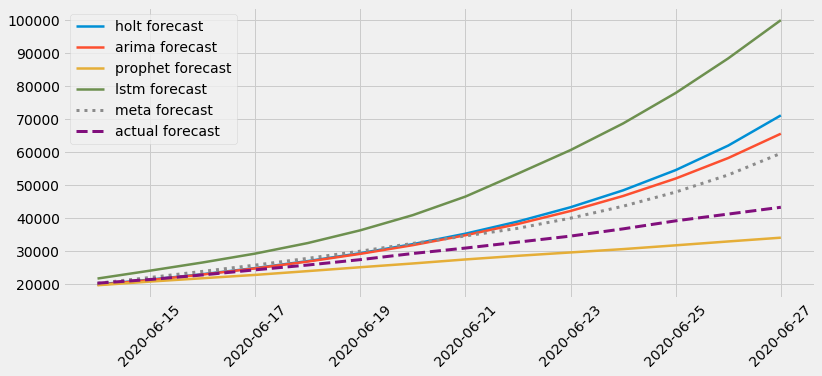

In [113]:
plt.figure(figsize = (12, 5))

start_pos = forecast_length * 6
end_pos = forecast_length * 7
for index, model in enumerate(models):
    mod_forecasts = pd.DataFrame(_test_x[:,index][start_pos:end_pos], columns = [feature])
    mod_forecasts["Date"] = forecast_dates
    mod_forecasts = mod_forecasts.set_index("Date")
    plot_forecast(mod_forecasts, model, linewidth=2.5)
    
meta_df = pd.DataFrame(forecasts[start_pos:end_pos], columns = [feature])
meta_df["Date"] = forecast_dates
meta_df = meta_df.set_index("Date")
plot_forecast(meta_df, "meta", ':')

actual_df = pd.DataFrame(_test_y[start_pos:end_pos], columns = [feature])
actual_df["Date"] = forecast_dates
actual_df = actual_df.set_index("Date")

plot_forecast(actual_df, "actual", '--')